In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allen_v1dd.client import OPhysClient

from allen_v1dd.stimulus_analysis import LocallySparseNoise
%load_ext autoreload
%autoreload 2

In [2]:
client = OPhysClient("/home/naomi/Desktop/data/V1dd_nwbs/")

mouse_id = "M427836"
col_vol_str = "23"
plane = 1

session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
lsn = LocallySparseNoise(session, plane, trace_type="events")


In [3]:
design_matrix_int = lsn.design_matrix.astype(int)  # shape (2*n_pixels, n_sweeps)

In [4]:
pixels_on = design_matrix_int[:112].reshape(*lsn.image_shape, design_matrix_int.shape[1])
pixels_on = np.select([pixels_on == 1, pixels_on == 0], [lsn.pixel_on, lsn.pixel_on / 2], pixels_on)

pixels_off = design_matrix_int[112:].reshape(*lsn.image_shape, design_matrix_int.shape[1])
pixels_off = np.select([pixels_off == 1, pixels_off == 0], [lsn.pixel_off, lsn.pixel_on / 2], pixels_off)

pixels = pixels_on + pixels_off
pixels = pixels - (lsn.pixel_on / 2) # center around 127.5
pixels.shape

(8, 14, 1705)

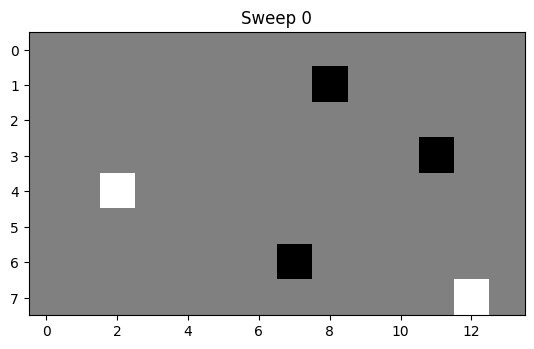

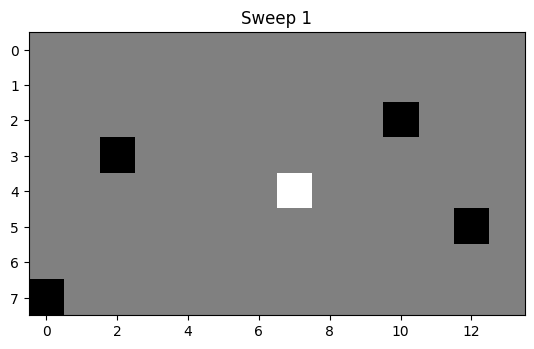

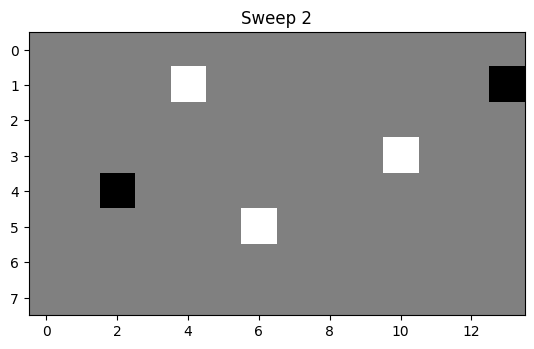

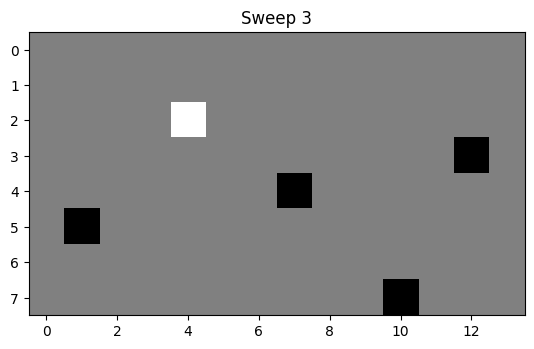

In [5]:
for i in range(4):
    plt.figure()
    plt.imshow(pixels[:, :, i], cmap='gray')
    plt.title(f"Sweep {i}")

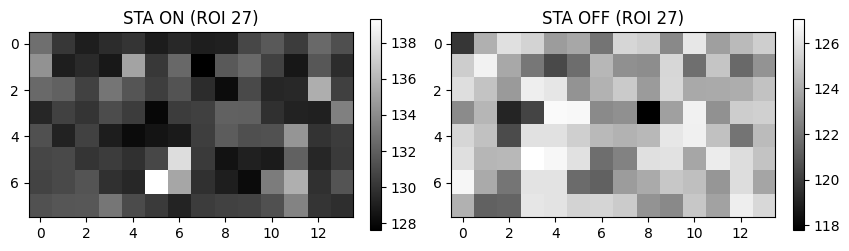

In [6]:
## spike triggered average RFs
roi = 27

on_sta = (pixels_on * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()
off_sta = (pixels_off * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sub = axs[0].imshow(on_sta, cmap='gray')
axs[0].set_title(f"STA ON (ROI {roi})")
fig.colorbar(sub, ax=axs[0], fraction=0.03)

sub = axs[1].imshow(off_sta, cmap='gray')
axs[1].set_title(f"STA OFF (ROI {roi})")
fig.colorbar(sub, ax=axs[1], fraction=0.03)

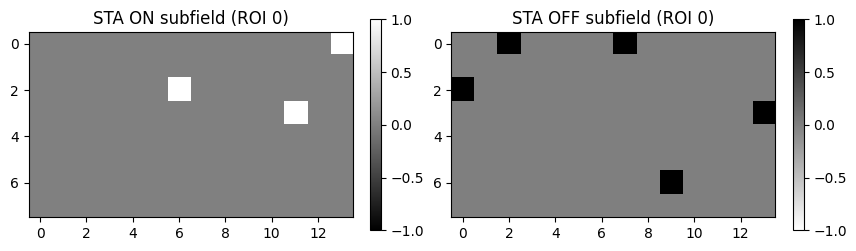

In [7]:
## z-scored to find STA subfields

roi = 0

on_sta = (pixels_on * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()
off_sta = (pixels_off * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()

on_sta = (on_sta - on_sta.mean()) / on_sta.std()
off_sta = (off_sta - off_sta.mean()) / off_sta.std()

on_subfield = on_sta > 3
off_subfield = off_sta < -3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sub = axs[0].imshow(on_subfield, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title(f"STA ON subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[0], fraction=0.03)

sub = axs[1].imshow(off_subfield, cmap='gray_r', vmin=-1, vmax=1)
axs[1].set_title(f"STA OFF subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[1], fraction=0.03)

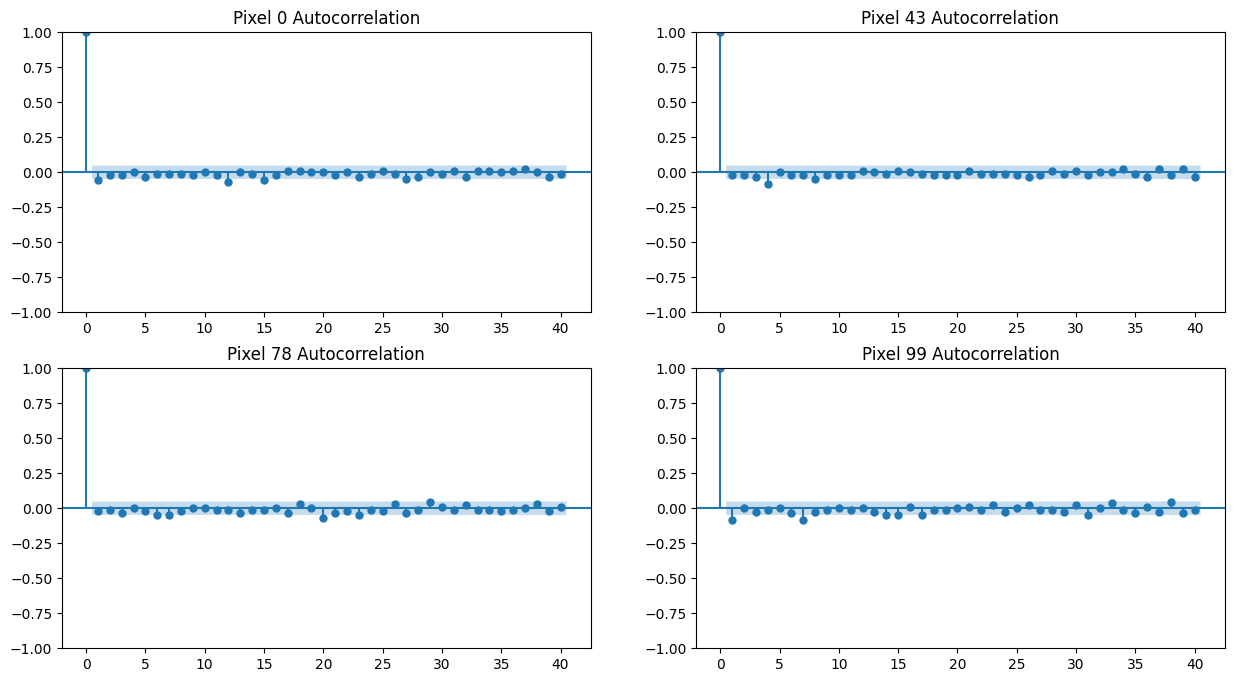

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

flattened_pixels = pixels.reshape(-1, pixels.shape[2])  # shape (n_pixels, n_sweeps)

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

for i, pixel_index in enumerate([0, 43, 78, 99]):
    fig = plot_acf(flattened_pixels[pixel_index], ax=axs[i//2, i%2], lags=40, alpha=0.05, title=f'Pixel {pixel_index} Autocorrelation')

In [9]:
x_coords = np.arange(14).repeat(8) * 9.3
y_coords = np.tile(np.arange(8), 14) * 9.3

coords = np.column_stack([x_coords, y_coords])

dx = coords[:, None, 0] - coords[None, :, 0]
dy = coords[:, None, 1] - coords[None, :, 1]
dist = np.sqrt(dx**2 + dy**2)  # (112, 112)

corrs = np.corrcoef(flattened_pixels)
corrs[np.eye(corrs.shape[0], dtype=bool)] = np.nan  # set diagonal to nan

mask = ~np.isnan(corrs)

dvals = dist[mask]
cvals = corrs[mask]

bins = np.arange(0, np.max(dist), 9.3)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mean_corr = []
sem_corr = []

for b0, b1 in zip(bins[:-1], bins[1:]):
    idx = (dvals >= b0) & (dvals < b1)
    mean_corr.append(np.nanmean(cvals[idx]))
    sem_corr.append(np.nanstd(cvals[idx]) / np.sqrt(np.sum(idx)))

mean_corr = np.array(mean_corr)
sem_corr = np.array(sem_corr)

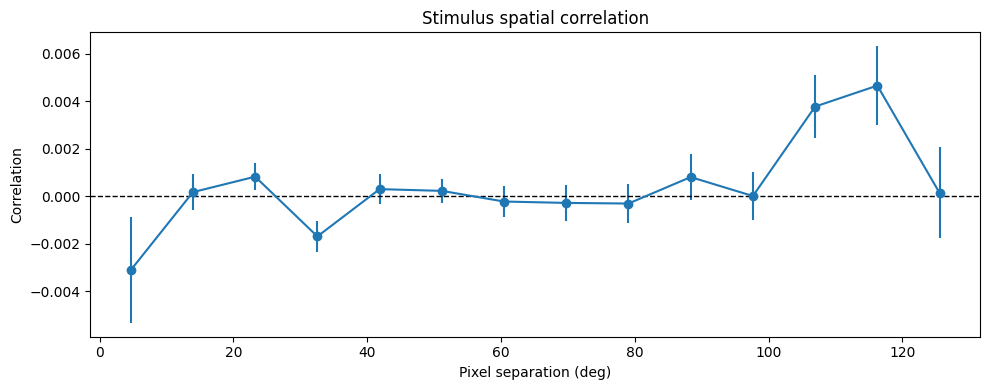

In [10]:
plt.figure(figsize=(10,4))
plt.errorbar(bin_centers, mean_corr, yerr=sem_corr, fmt='o-')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Pixel separation (deg)')
plt.ylabel('Correlation')
plt.title('Stimulus spatial correlation')
plt.tight_layout()
plt.show()

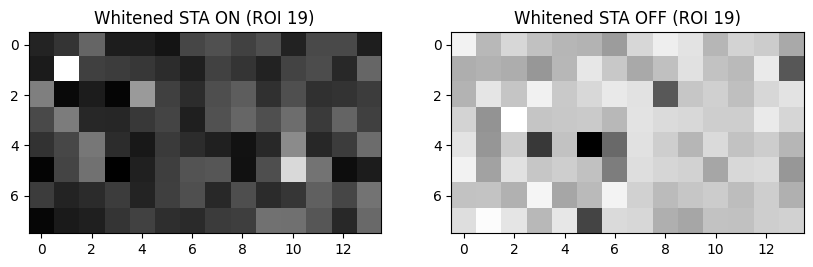

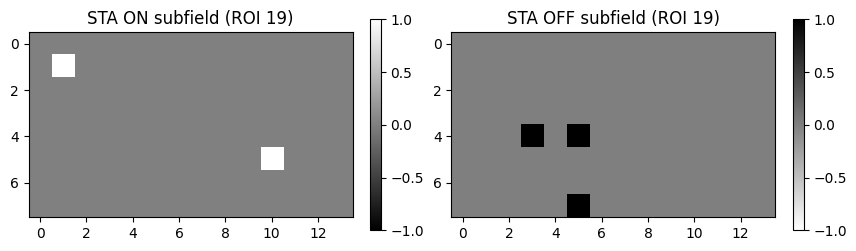

In [393]:
## estimate stimulus covariance to whiten the stimulus
roi = 19

mu = np.mean(flattened_pixels, axis=1, keepdims=True)
centered_pixels = flattened_pixels - mu  # shape (n_pixels, n_sweeps
cov_matrix = np.cov(centered_pixels)  # shape (n_pixels, n_pixels)

on_sta = (pixels_on * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()
off_sta = (pixels_off * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()

centered_on_sta = on_sta.flatten() - mu.flatten()
centered_off_sta = off_sta.flatten() - mu.flatten()

lam = 1e-3  # regularization parameter
A = cov_matrix + lam * np.eye(cov_matrix.shape[0])
k_on = np.linalg.solve(A, centered_on_sta)  # whitened STA
k_off = np.linalg.solve(A, centered_off_sta)  # whitened STA

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(k_on.reshape(lsn.image_shape), cmap='gray')
axs[0].set_title(f"Whitened STA ON (ROI {roi})")
axs[1].imshow(k_off.reshape(lsn.image_shape), cmap='gray')
axs[1].set_title(f"Whitened STA OFF (ROI {roi})")

k_on_z_scored = (k_on - k_on.mean()) / k_on.std()
k_off_z_scored = (k_off - k_off.mean()) / k_off.std()
on_subfield = k_on_z_scored > 3
off_subfield = k_off_z_scored < -3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sub = axs[0].imshow(on_subfield.reshape(lsn.image_shape), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title(f"STA ON subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[0], fraction=0.03)

sub = axs[1].imshow(off_subfield.reshape(lsn.image_shape), cmap='gray_r', vmin=-1, vmax=1)
axs[1].set_title(f"STA OFF subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[1], fraction=0.03)

## let's try to implement the method from this paper: https://www.nature.com/articles/s41467-022-29999-7#Sec9

- they used mice with GCaMP6s and performed 2P calcium imaging in the primary visual cortex
- they considered neurons at depths below 300 um to be from layer 4 -- estimate that 75% of their data is from layer 2/3 and 25% is from layer 4

- for each cell and tile (i.e. pixel) in the stimulus, calculate the average response the neuron locked to the presentation of a bright or dark spot over the 15 frames (1 sec) following stimulus onset --> our stimulus was presented at 3 Hz, so we should look at the next 3 frames following the stimulus 

In [23]:
lsn_stim_table, metadata = session.get_stimulus_table(stim_name="locally_sparse_noise")

stim_frame_duration = metadata['duration']
n_sweeps = metadata['num_samples']
grid_size = metadata['grid_size']  # 9.3 degrees 

print(f"Stimulus frame duration: {stim_frame_duration} s")
print(f"Number of sweeps: {n_sweeps}")
print(f"Grid size: {grid_size} degrees")

lsn_stim_table

Stimulus frame duration: 0.33000001311302185 s
Number of sweeps: 1705
Grid size: 9.3 degrees


,start,end,frame
0,633.410400,633.710571,0
1,633.727295,634.027527,1
2,634.044189,634.344421,2
3,634.361145,634.661377,3
4,634.678101,634.978333,4
...,...,...,...
1700,2094.960205,2095.260498,107
1701,2095.277100,2095.577393,108
1702,2095.593994,2095.894287,109
1703,2095.910889,2096.211182,110


In [353]:
session_events = session.get_traces(plane=plane, trace_type="events")

print(f'Shape of session_events: {session_events.shape}')  # (n_rois, n_total_frames) (includes all stimulus and non-stimulus periods)

results = {
    'trial_id': [],  # sweep index
    'pixel_id': [], # pixel index (0 to 223)
    'avg_response': [],  # average response (over the 3 frames) to that pixel being on or off (trials)
    'tau': [],  # time lag between stimulus onset and response measurement
}

num_frames_for_resp = 3 # corresponds with about 1 second
for tau in [-8, -7, -6, -5, -4, -3, -2]:
    starts = lsn_stim_table.start.values
    for i, start in enumerate(starts):
        start_idx = np.where(session_events.time >= start)[0][0]
        # resp = np.mean(session_events.data[:, start_idx: start_idx + num_frames_for_resp], axis=1)  # average over num_frames_for_resp frames
        resp = session_events.data[:, start_idx + tau] # response at specific frame after stimulus onset

        for pixel_id in np.where(design_matrix_int[:, i] == 1)[0]:
            results['trial_id'].append(i)
            results['pixel_id'].append(pixel_id)
            results['avg_response'].append(resp[14])  # for a specific ROI    
            results['tau'].append(tau)

results_df = pd.DataFrame(results)
pixel_means = results_df.groupby('pixel_id')['avg_response'].mean()
results_df_mean_baseline = pd.DataFrame(zip(pixel_means.index, pixel_means.values), columns=['pixel_id', 'mean_response'])
# results_df_mean

Shape of session_events: (1170, 21490)


Text(0.5, 1.0, 'Mean response to OFF pixels')

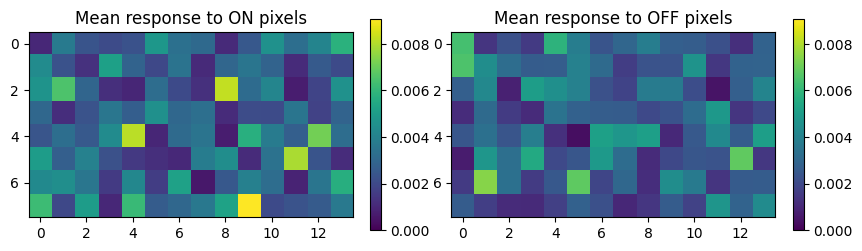

In [354]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sub1 = axs[0].imshow(results_df_mean_baseline.mean_response.values[:112].reshape(lsn.image_shape), vmin=0, vmax=results_df_mean_baseline.mean_response.values.max())
plt.colorbar(sub1, ax=axs[0], fraction=0.03)
axs[0].set_title(f'Mean response to ON pixels')

sub2 = axs[1].imshow(results_df_mean_baseline.mean_response.values[112:].reshape(lsn.image_shape), vmin=0, vmax=results_df_mean_baseline.mean_response.values.max())
plt.colorbar(sub2, ax=axs[1], fraction=0.03)
axs[1].set_title(f'Mean response to OFF pixels')


In [430]:
import scipy.optimize as opt

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(data):
    '''
    data: 2D numpy array (lsn.image_shape) of average response to ON or OFF pixels
    ''' 

    # Figure out initial guess parameters
    idx = np.argmax(np.abs(data))
    x0_0, y0_0 = idx % data.shape[1], idx // data.shape[1]
    A0 = data[y0_0, x0_0] - np.median(data)
    B0 = np.median(data)
    initial_guess = (A0, x0_0, y0_0, 1, 1, 0, B0)

    # Create x and y coordinate arrays
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)

    # Try fitting the Gaussian model to the data
    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data.reshape(-1), p0=initial_guess, maxfev=10000)

        fitted_data = twoD_Gaussian((x, y), *popt).reshape(data.shape)

        resid = data - fitted_data
        ss_res = np.sum(resid**2)
        ss_tot = np.sum((data - data.mean())**2) + 1e-12
        r2 = 1 - ss_res / ss_tot

        return popt, pcov, fitted_data, r2
    except:
        return None, None, np.zeros_like(data), None


Shape of session_events: (1170, 21490)


/home/naomi/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


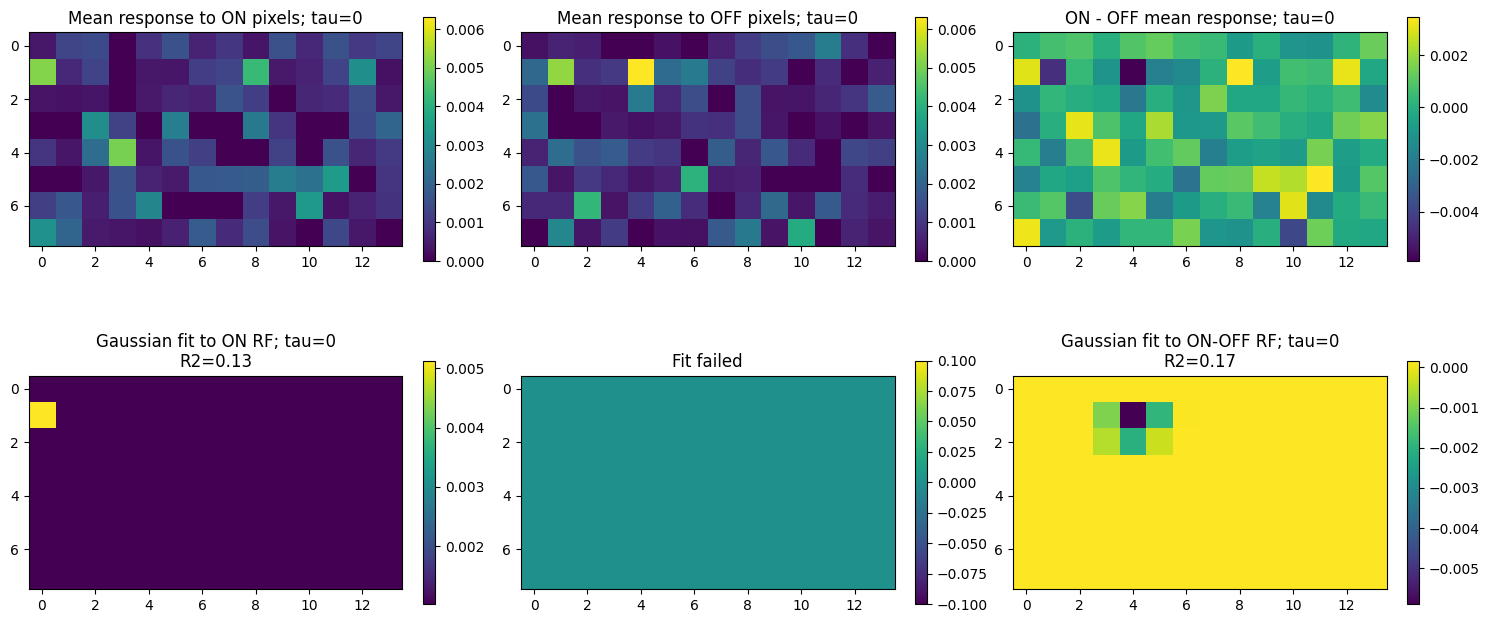

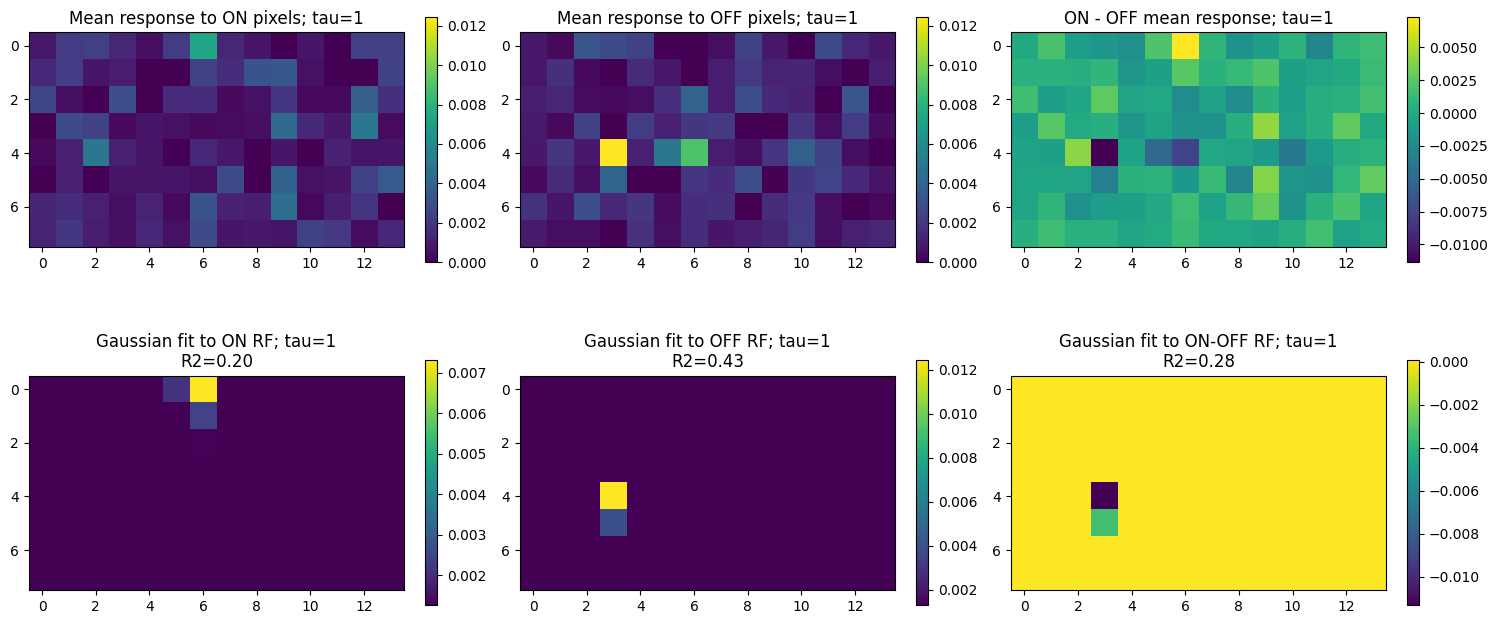

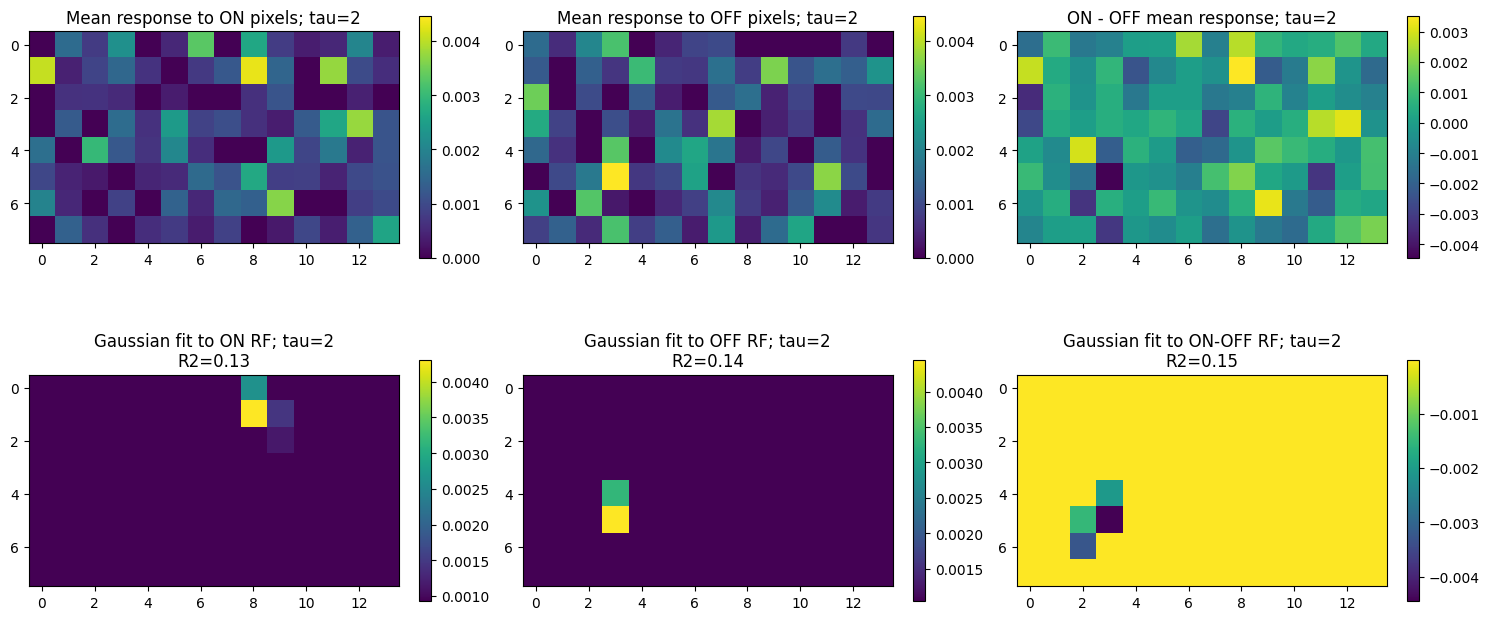

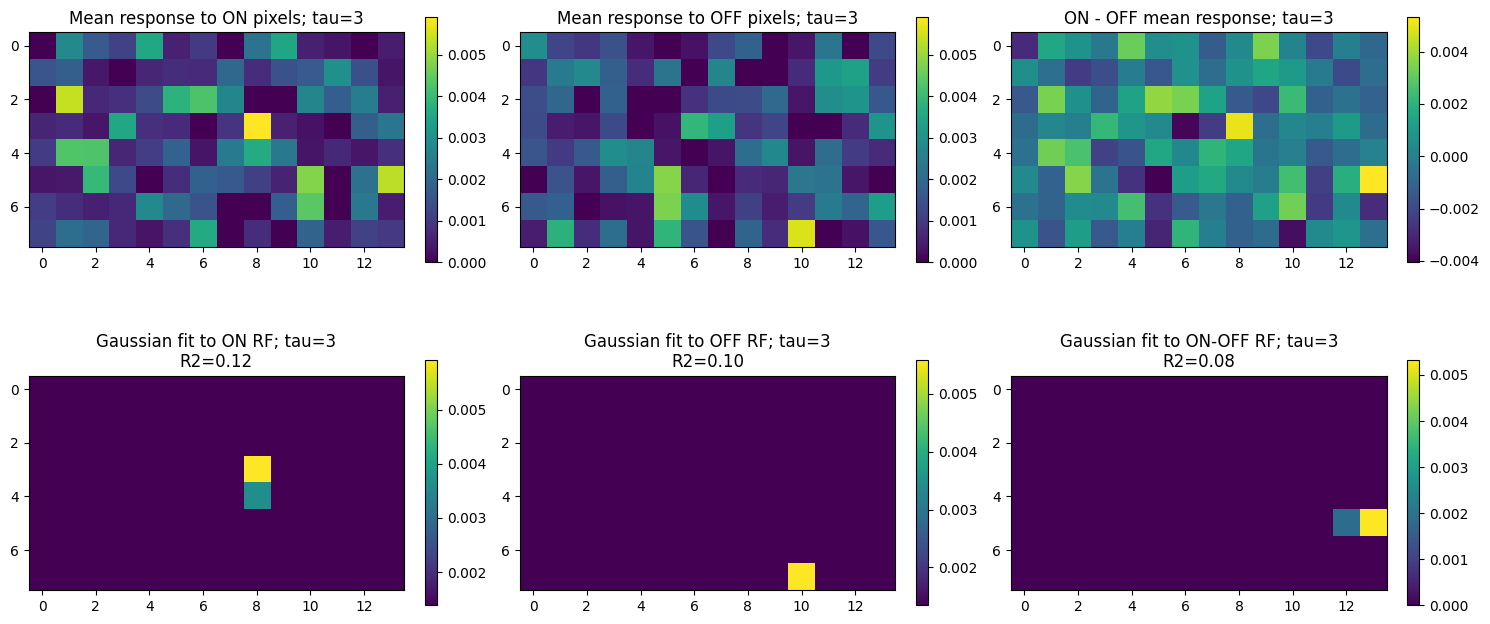

In [431]:
session_events = session.get_traces(plane=plane, trace_type="events")

print(f'Shape of session_events: {session_events.shape}')  # (n_rois, n_total_frames) (includes all stimulus and non-stimulus periods)



for tau in [0, 1, 2, 3]: 
    starts = lsn_stim_table.start.values

    results = {
        'trial_id': [],  # sweep index
        'pixel_id': [], # pixel index (0 to 223)
        'avg_response': [],  # average response (over the 3 frames) to that pixel being on or off (trials)
    }
    
    for i, start in enumerate(starts):
        start_idx = np.where(session_events.time >= start)[0][0]
        # resp = np.mean(session_events.data[:, start_idx: start_idx + num_frames_for_resp], axis=1)  # average over num_frames_for_resp frames
        resp = session_events.data[:, start_idx + tau] # response at specific frame after stimulus onset

        for pixel_id in np.where(design_matrix_int[:, i] == 1)[0]:
            results['trial_id'].append(i)
            results['pixel_id'].append(pixel_id)
            results['avg_response'].append(resp[23])  # for a specific ROI    

    results_df = pd.DataFrame(results)
    pixel_means = results_df.groupby('pixel_id')['avg_response'].mean()
    results_df_mean_tau1 = pd.DataFrame(zip(pixel_means.index, pixel_means.values), columns=['pixel_id', 'mean_response'])

    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    sub1 = axs[0, 0].imshow(results_df_mean_tau1.mean_response.values[:112].reshape(lsn.image_shape), vmin=0, vmax=results_df_mean_tau1.mean_response.values.max(), cmap='viridis')
    plt.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
    axs[0, 0].set_title(f'Mean response to ON pixels; tau={tau}')

    sub2 = axs[0, 1].imshow(results_df_mean_tau1.mean_response.values[112:].reshape(lsn.image_shape), vmin=0, vmax=results_df_mean_tau1.mean_response.values.max(), cmap='viridis')
    plt.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
    axs[0, 1].set_title(f'Mean response to OFF pixels; tau={tau}')
    
    sub3 = axs[0, 2].imshow((results_df_mean_tau1.mean_response.values[:112] - results_df_mean_tau1.mean_response.values[112:]).reshape(lsn.image_shape))
    plt.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
    axs[0, 2].set_title(f'ON - OFF mean response; tau={tau}')

    ## GAUSSIAN FITTING TO RFs
    data = results_df_mean_tau1.mean_response.values[:112].reshape(lsn.image_shape) # ON SUBFIELD
    popt, pcov, fitted_data, r2 = fit_gaussian(data)
    sub4 = axs[1, 0].imshow(fitted_data, cmap='viridis')
    plt.colorbar(sub4, ax=axs[1, 0], fraction=0.03)
    axs[1, 0].set_title(f'Gaussian fit to ON RF; tau={tau}\nR2={r2:.2f}' if r2 is not None else "Fit failed")


    ## GAUSSIAN FITTING TO RFs
    data = results_df_mean_tau1.mean_response.values[112:].reshape(lsn.image_shape) # OFF SUBFIELD
    popt, pcov, fitted_data, r2 = fit_gaussian(data)
    sub4 = axs[1, 1].imshow(fitted_data, cmap='viridis')
    plt.colorbar(sub4, ax=axs[1, 1], fraction=0.03)
    axs[1, 1].set_title(f'Gaussian fit to OFF RF; tau={tau}\nR2={r2:.2f}' if r2 is not None else "Fit failed")

    ## GAUSSIAN FITTING TO RFs
    data = results_df_mean_tau1.mean_response.values[:112].reshape(lsn.image_shape) - results_df_mean_tau1.mean_response.values[112:].reshape(lsn.image_shape)  # ON-OFF SUBFIELD
    popt, pcov, fitted_data, r2 = fit_gaussian(data)
    sub4 = axs[1, 2].imshow(fitted_data, cmap='viridis')
    plt.colorbar(sub4, ax=axs[1, 2], fraction=0.03)
    axs[1, 2].set_title(f'Gaussian fit to ON-OFF RF; tau={tau}\nR2={r2:.2f}' if r2 is not None else "Fit failed")

    plt.tight_layout()

    # print(f'Norm of ON kernel at tau={tau}: {np.linalg.norm(results_df_mean_tau1.mean_response.values[:112]) / np.linalg.norm(results_df_mean_baseline.mean_response.values[:112])}')
    # print(f'Norm of OFF kernel at tau={tau}: {np.linalg.norm(results_df_mean_tau1.mean_response.values[112:]) / np.linalg.norm(results_df_mean_baseline.mean_response.values[112:])}')

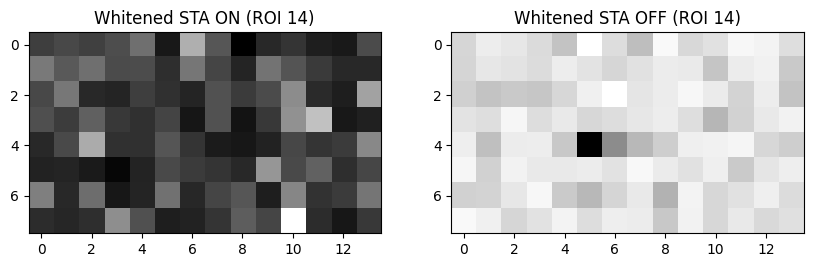

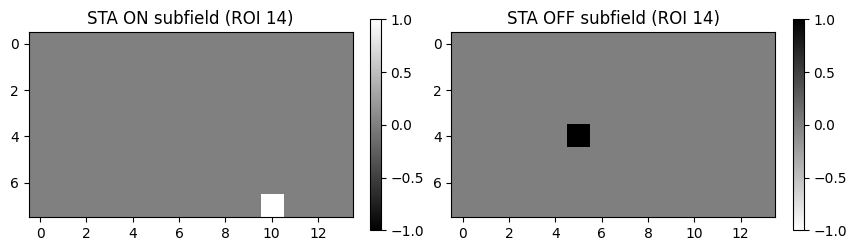

In [493]:
## estimate stimulus covariance to whiten the stimulus
roi = 14

mu = np.mean(flattened_pixels, axis=1, keepdims=True)
centered_pixels = flattened_pixels - mu  # shape (n_pixels, n_sweeps
cov_matrix = np.cov(centered_pixels)  # shape (n_pixels, n_pixels)

on_sta = (pixels_on * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()
off_sta = (pixels_off * lsn.sweep_responses[:, roi]).sum(axis=2) / lsn.sweep_responses[:, roi].sum()

centered_on_sta = on_sta.flatten() - mu.flatten()
centered_off_sta = off_sta.flatten() - mu.flatten()

lam = 1e-3  # regularization parameter
A = cov_matrix + lam * np.eye(cov_matrix.shape[0])
k_on = np.linalg.solve(A, centered_on_sta)  # whitened STA
k_off = np.linalg.solve(A, centered_off_sta)  # whitened STA

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(k_on.reshape(lsn.image_shape), cmap='gray')
axs[0].set_title(f"Whitened STA ON (ROI {roi})")
axs[1].imshow(k_off.reshape(lsn.image_shape), cmap='gray')
axs[1].set_title(f"Whitened STA OFF (ROI {roi})")

k_on_z_scored = (k_on - k_on.mean()) / k_on.std()
k_off_z_scored = (k_off - k_off.mean()) / k_off.std()
on_subfield = k_on_z_scored > 3
off_subfield = k_off_z_scored < -3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sub = axs[0].imshow(on_subfield.reshape(lsn.image_shape), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title(f"STA ON subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[0], fraction=0.03)

sub = axs[1].imshow(off_subfield.reshape(lsn.image_shape), cmap='gray_r', vmin=-1, vmax=1)
axs[1].set_title(f"STA OFF subfield (ROI {roi})")
fig.colorbar(sub, ax=axs[1], fraction=0.03)

Good fit for OFF RF with R2=0.64


Text(0.5, 1.0, 'Gaussian fit to OFF RF; tau=3\nR2=0.64')

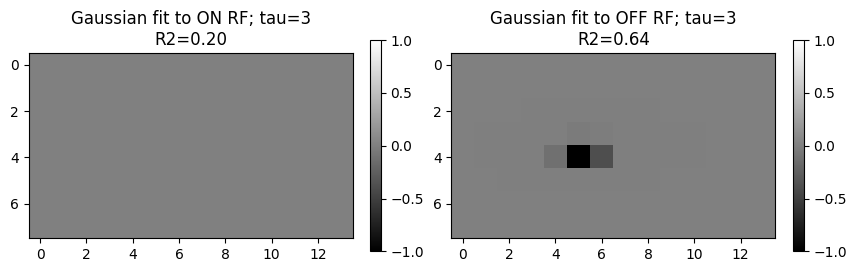

In [494]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
r2_threshold = 0.2
res = 1

data = k_on.reshape(lsn.image_shape)
popt, pcov, fitted_data, r2 = fit_gaussian(data)

# Generate fitted data for visualization
x = np.arange(0, data.shape[1], res)
y = np.arange(0, data.shape[0], res)
x, y = np.meshgrid(x, y)

fitted_data = twoD_Gaussian((x, y), *popt).reshape(int(data.shape[0]*(1/res)), int(data.shape[1]*(1/res)))
if r2 > r2_threshold:
    print(f'Good fit for OFF RF with R2={r2:.2f}')
    subfield = (fitted_data - np.median(fitted_data)) / np.max(np.abs(fitted_data - np.median(fitted_data)))
else:
    subfield = np.zeros_like(data)

sub4 = axs[0].imshow(subfield, cmap='binary_r', vmin=-1, vmax=1)
plt.colorbar(sub4, ax=axs[0], fraction=0.03)
axs[0].set_title(f'Gaussian fit to ON RF; tau={tau}\nR2={r2:.2f}' if r2 is not None else "Fit failed")

data = k_off.reshape(lsn.image_shape)
popt, pcov, fitted_data, r2 = fit_gaussian(data)

# Generate fitted data for visualization
x = np.arange(0, data.shape[1], res)
y = np.arange(0, data.shape[0], res)
x, y = np.meshgrid(x, y)

fitted_data = twoD_Gaussian((x, y), *popt).reshape(int(data.shape[0]*(1/res)), int(data.shape[1]*(1/res)))
if r2 > r2_threshold:
    print(f'Good fit for OFF RF with R2={r2:.2f}')
    subfield = (fitted_data - np.median(fitted_data)) / np.max(np.abs(fitted_data - np.median(fitted_data)))
else:
    subfield = np.zeros_like(data)

sub4 = axs[1].imshow(subfield, cmap='binary_r', vmin=-1, vmax=1)
plt.colorbar(sub4, ax=axs[1], fraction=0.03)
axs[1].set_title(f'Gaussian fit to OFF RF; tau={tau}\nR2={r2:.2f}' if r2 is not None else "Fit failed")

In [401]:
fitted_data

array([[-0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193],
       [-0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193],
       [-0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193],
       [-0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376196, -0.00376193, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00376193, -0.00376193, -0.00376193],
       [-0.00376193, -0.00376193, -0.00376193, -0.00376193, -0.00376194,
        -0.02494681, -0.01362288, -0.00376193, -0.00376193, -0.00376193,
        -0.00376193, -0.00

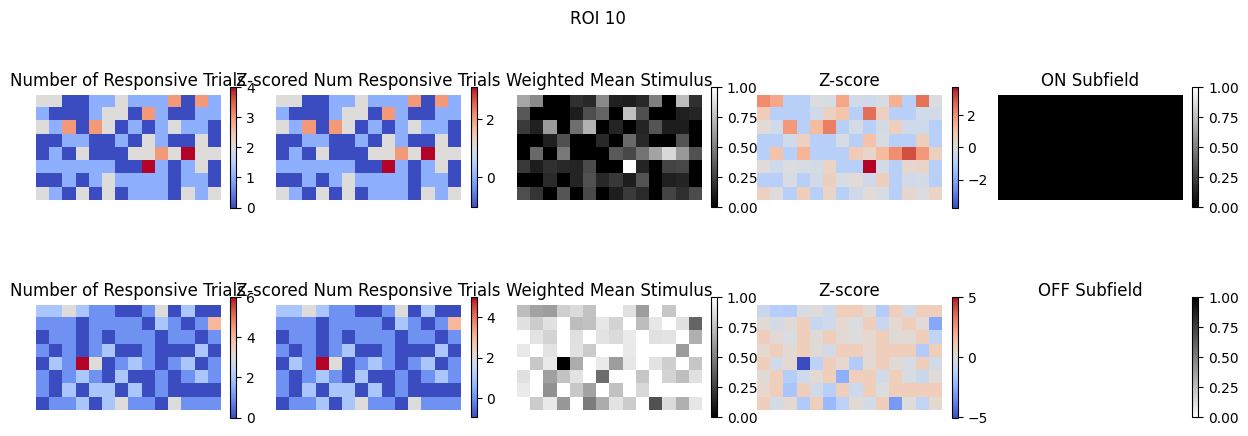

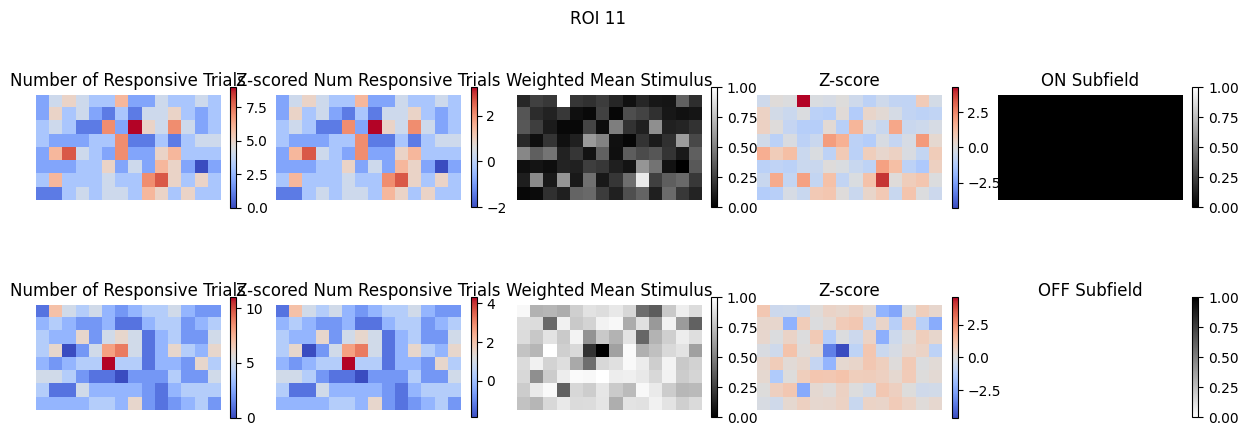

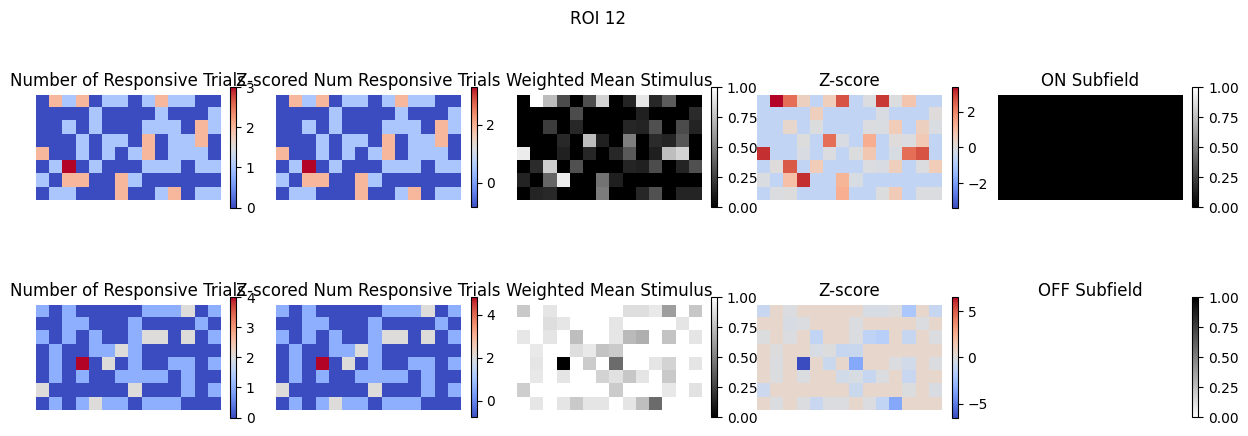

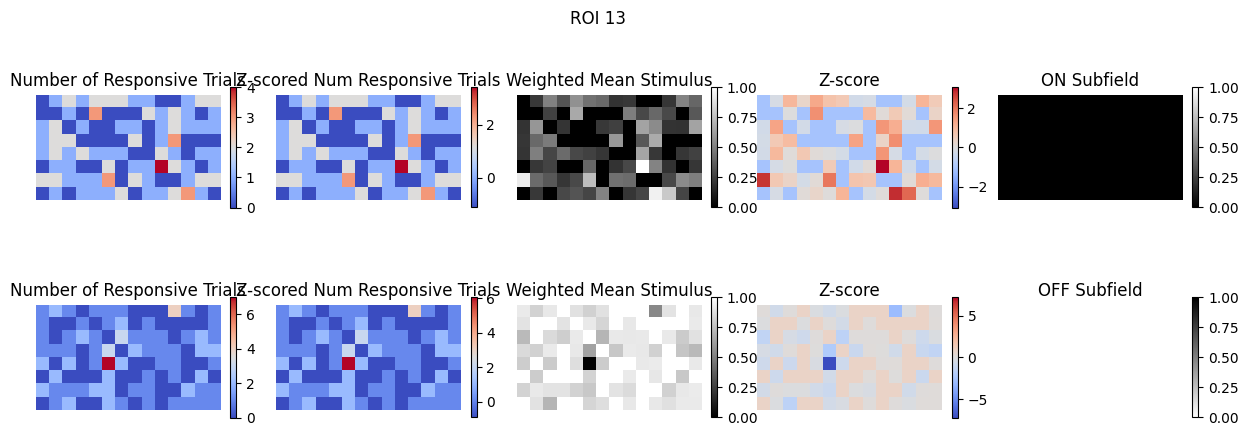

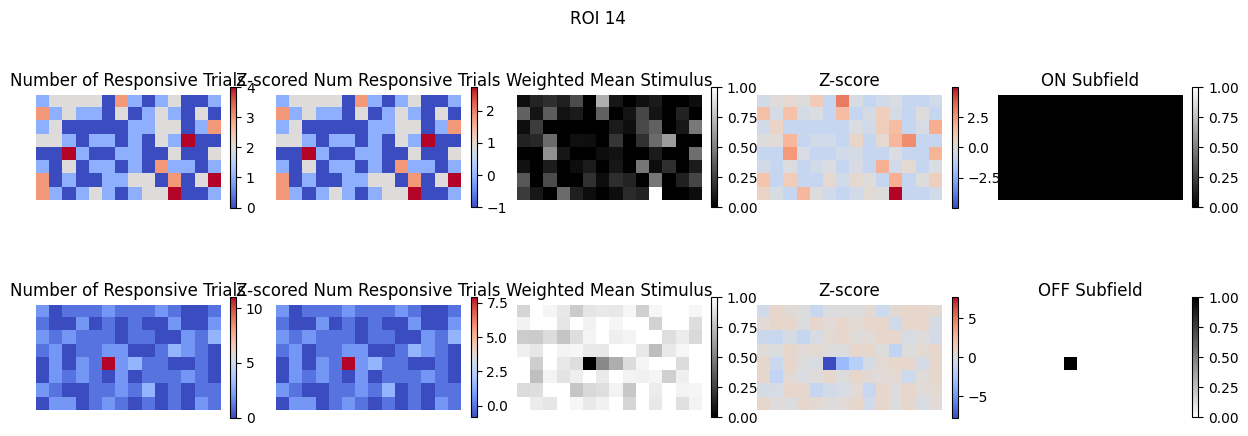

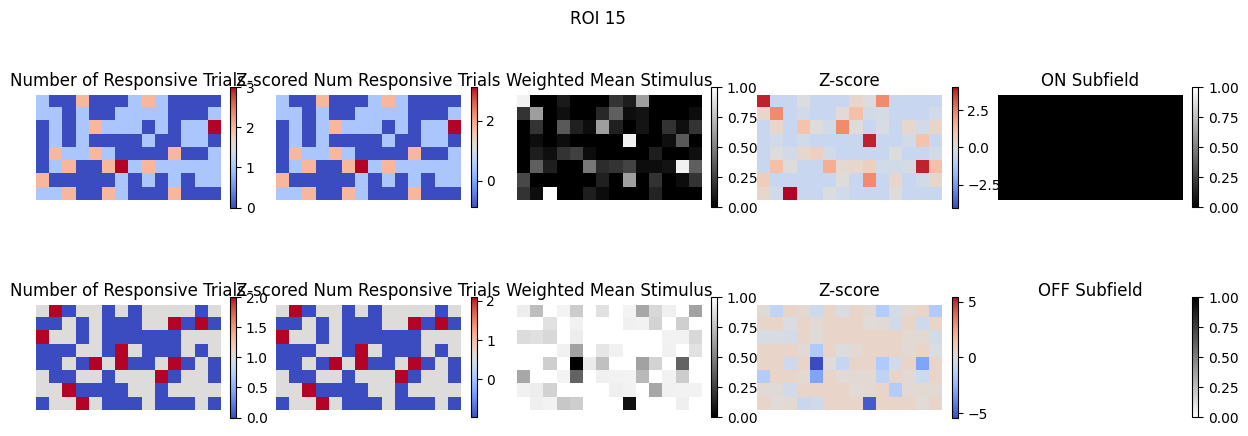

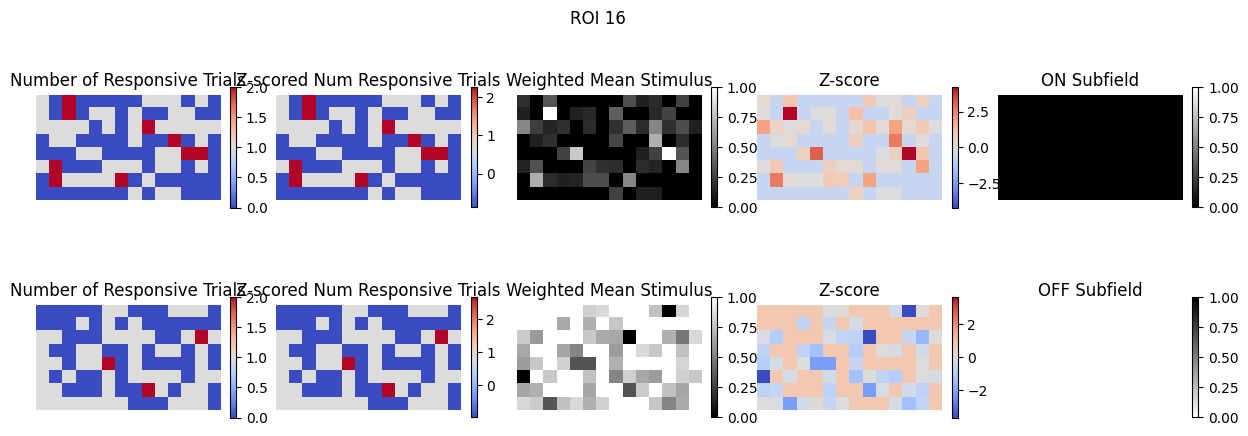

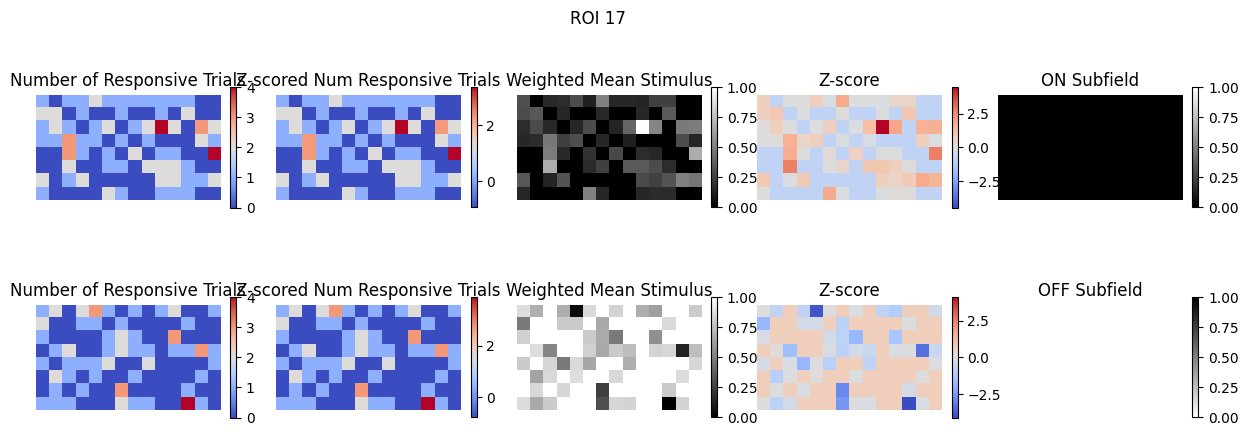

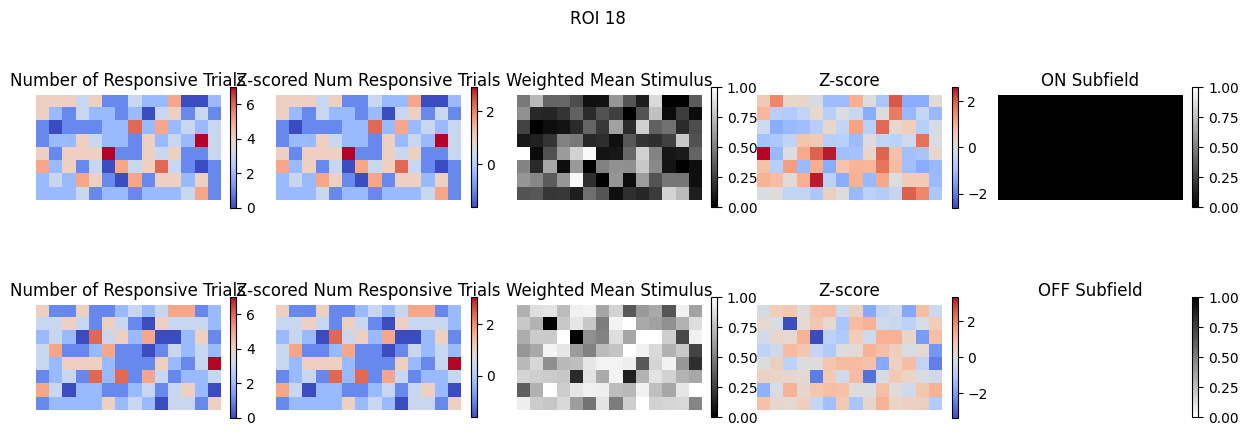

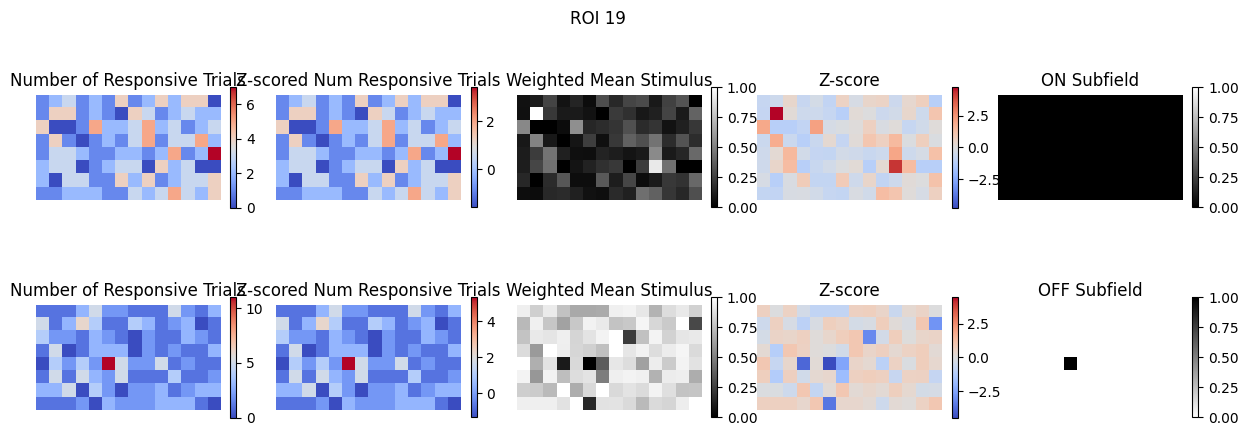

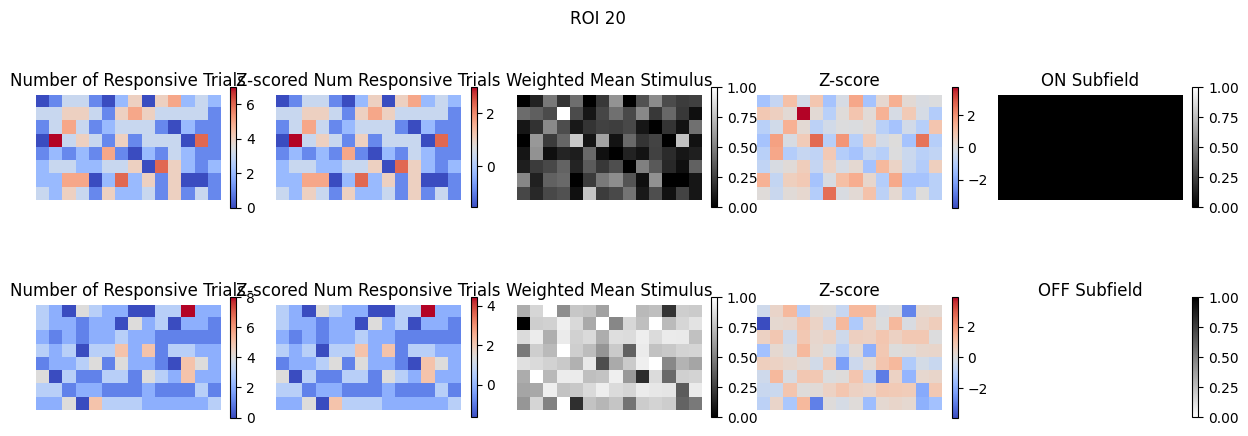

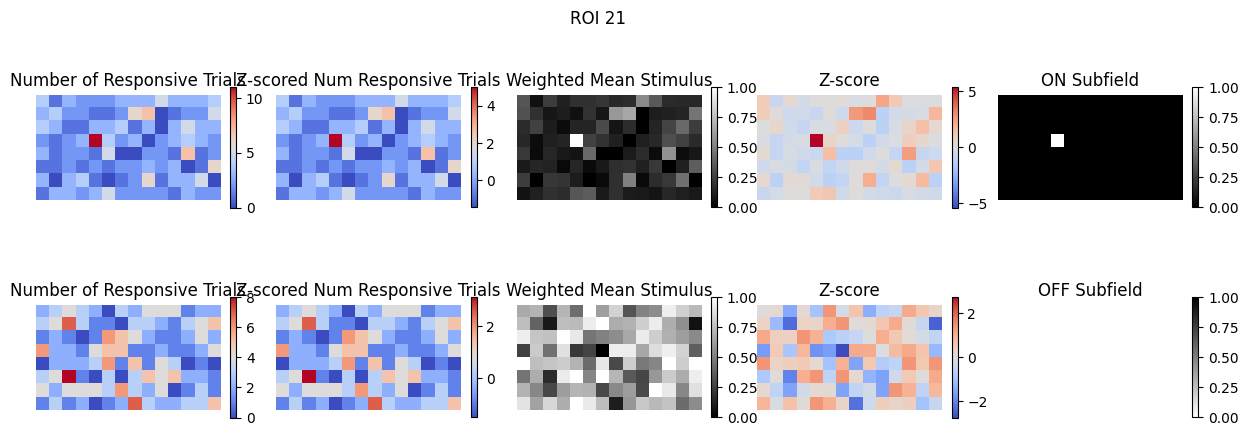

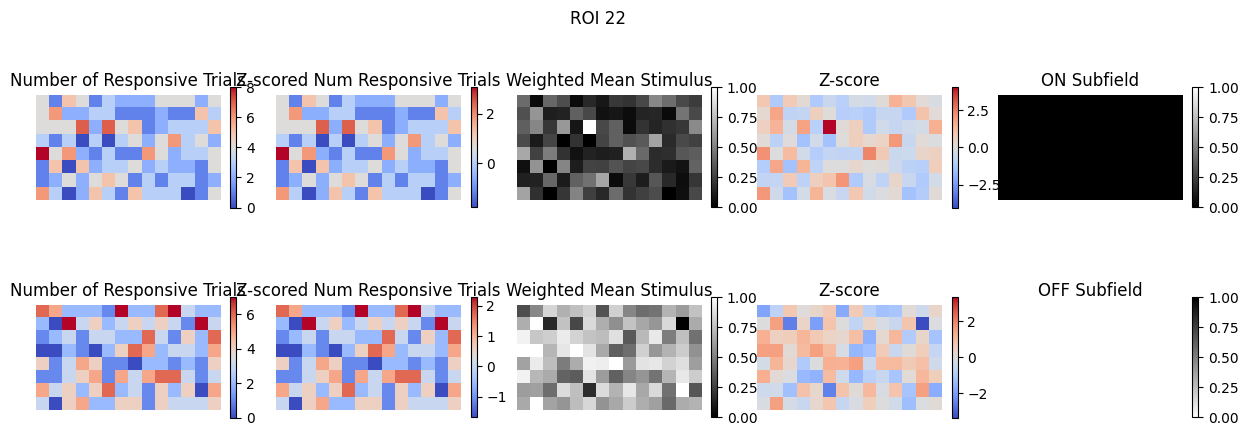

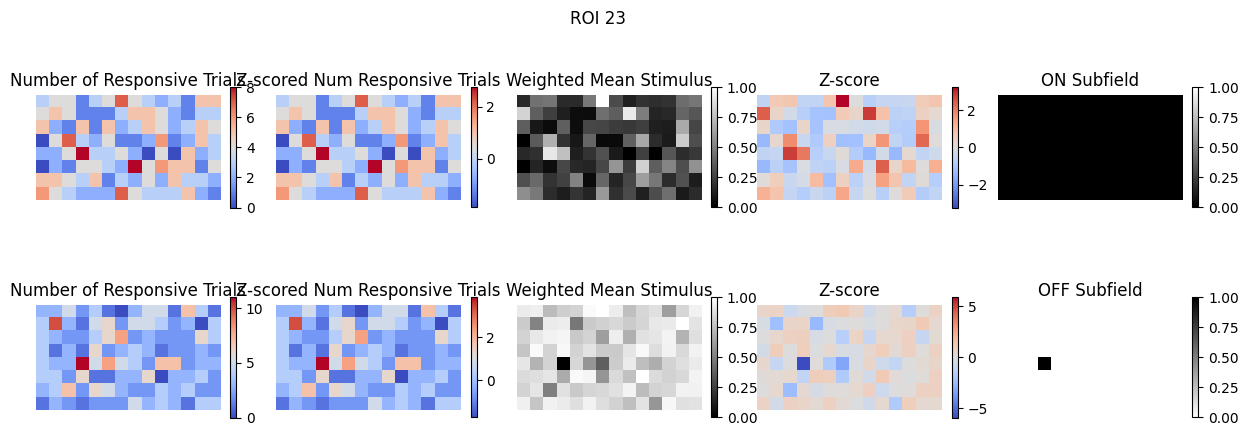

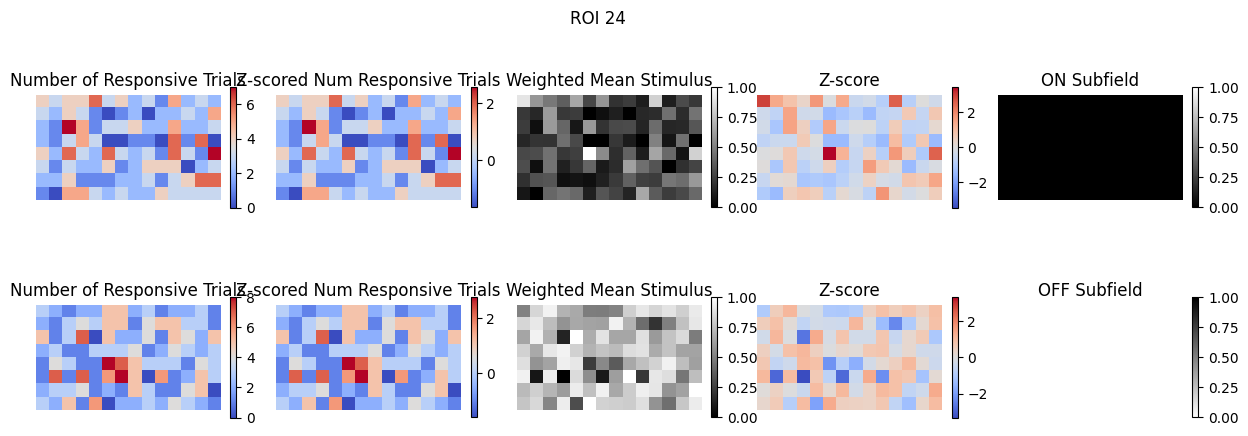

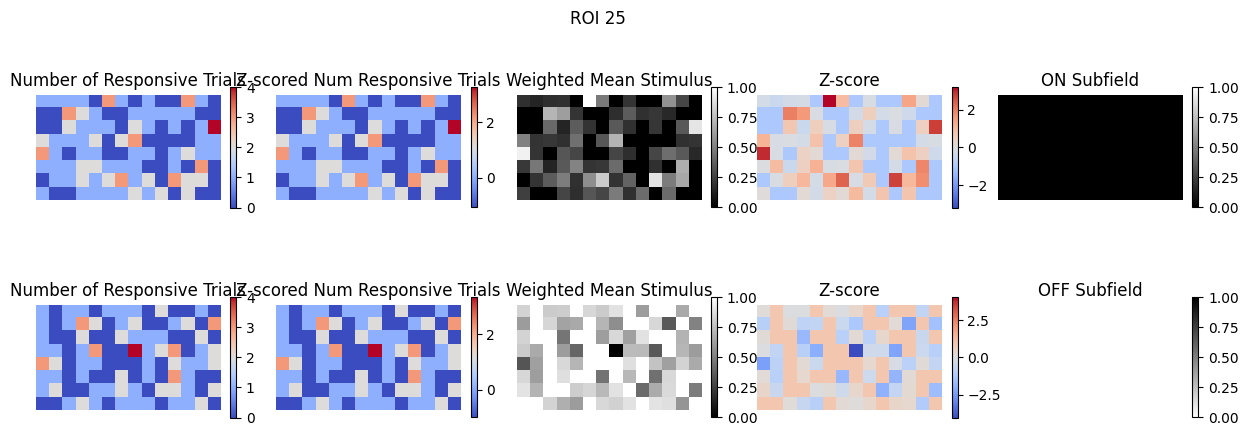

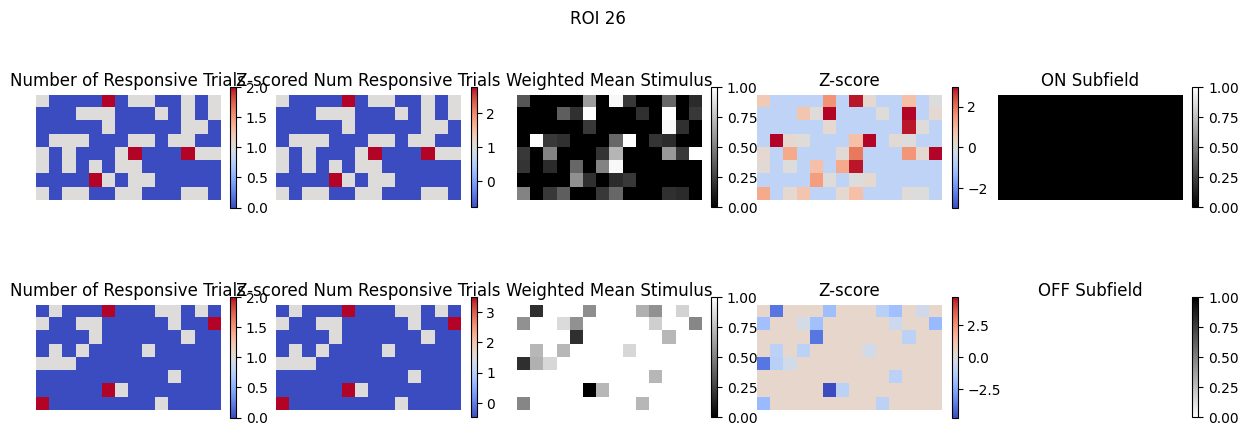

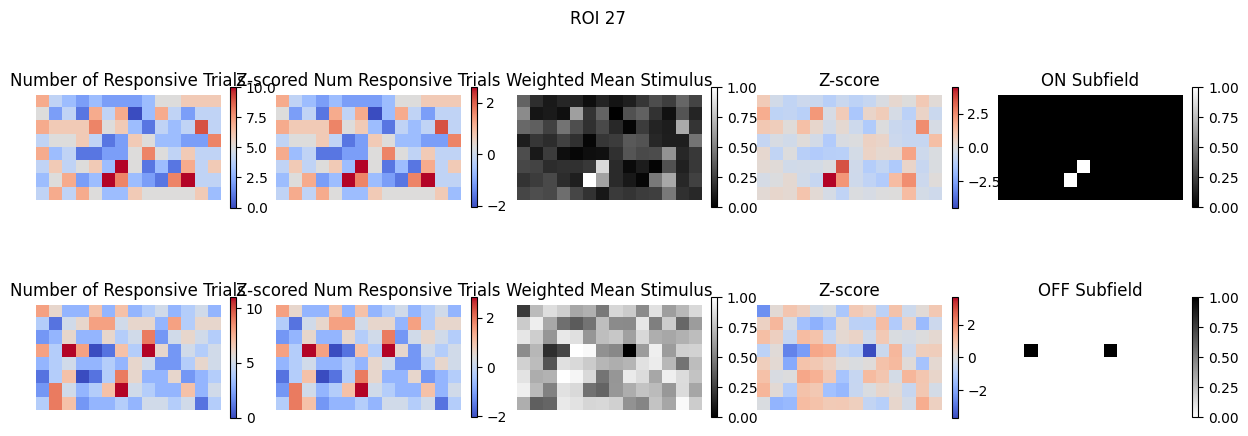

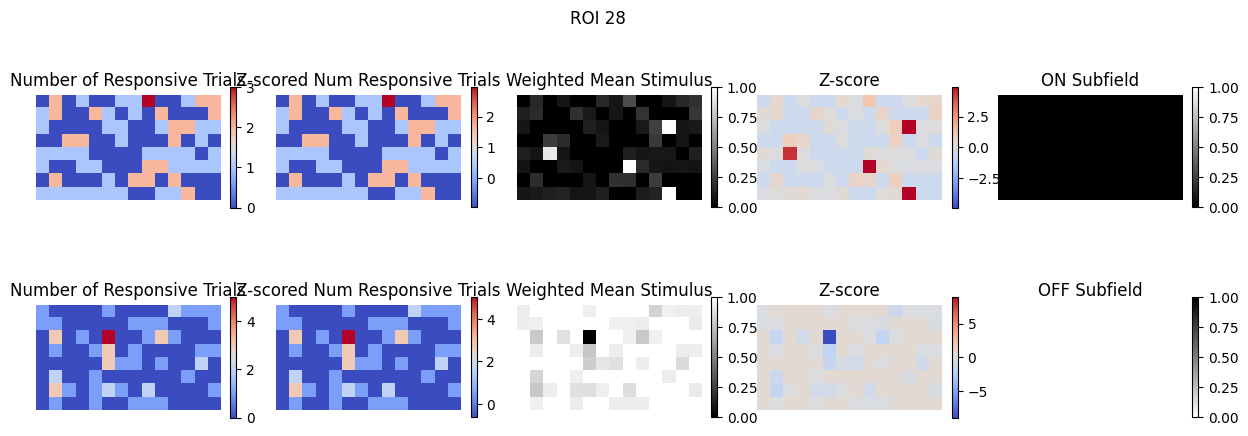

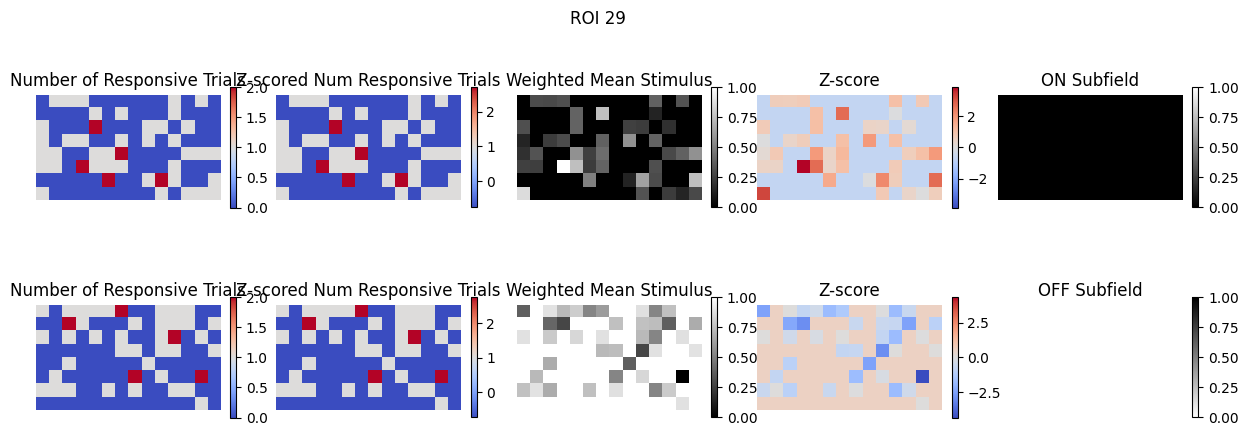

In [3]:
for roi in range(10, 30):
    fig, axs = lsn.visualize_receptive_fields(roi)
    fig.suptitle(f"ROI {roi}")
    plt.show()

In [4]:
receptive_fields_new = lsn.receptive_fields_new

<Axes: title={'center': 'ON receptive field'}, xlabel='Azimuth (°)', ylabel='Altitude (°)'>

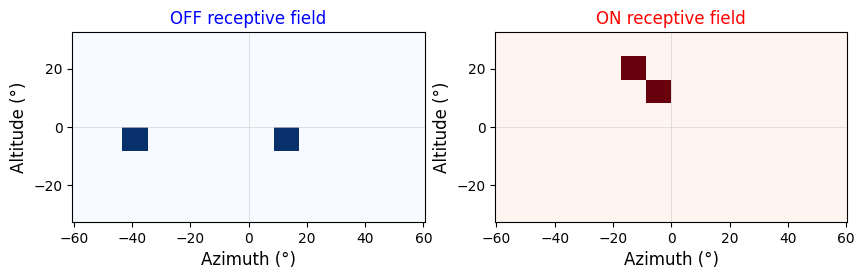

In [5]:
roi = 27
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Ridge RF - OFF")
lsn.plot_rf(receptive_fields_new[roi, 1, :, :], rf_type="off", ax=axs[0])
axs[1].set_title("Ridge RF - ON")   

lsn.plot_rf(receptive_fields_new[roi, 0, :, :], rf_type="on", ax=axs[1])

In [6]:
receptive_fields_sta = lsn.receptive_fields_sta

<Axes: title={'center': 'ON receptive field'}, xlabel='Azimuth (°)', ylabel='Altitude (°)'>

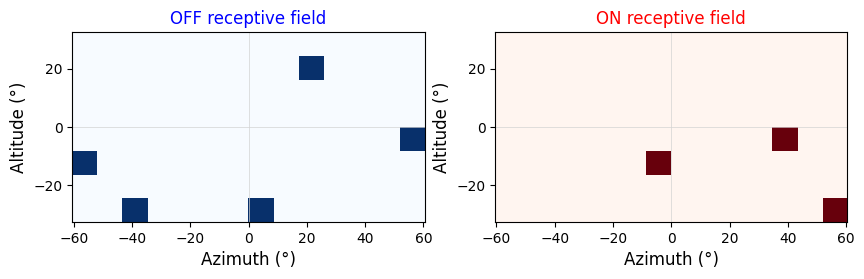

In [40]:
roi = 0
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Ridge RF - OFF")
lsn.plot_rf(receptive_fields_sta[roi, 1, :, :], rf_type="off", ax=axs[0])
axs[1].set_title("Ridge RF - ON")

lsn.plot_rf(receptive_fields_sta[roi, 0, :, :], rf_type="on", ax=axs[1])

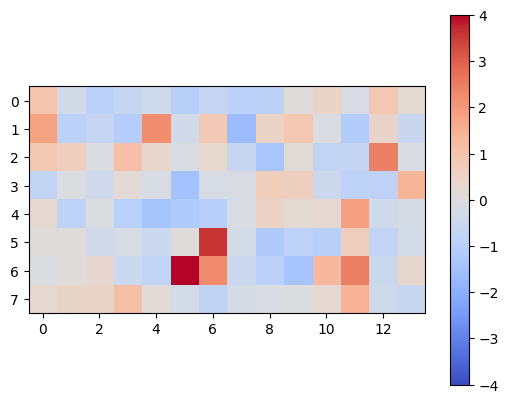

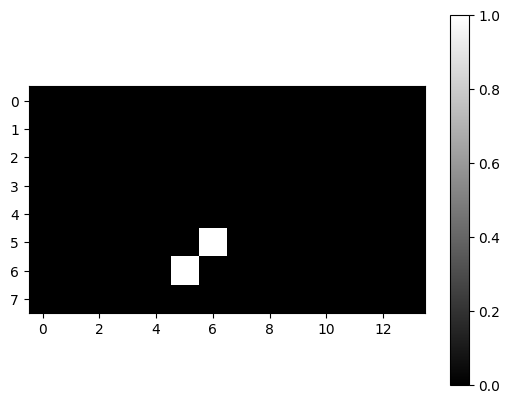

In [94]:
## spike-triggered averages

sta = (pixels_on * sweep_responses_roi).sum(axis=2) / sweep_responses_roi.sum()

sta = (sta - sta.mean()) / sta.std()
subfield = sta > 3

sub = plt.imshow(sta[:, :], cmap='coolwarm', vmin=-4, vmax=4)
plt.colorbar(sub)

plt.figure()
sub = plt.imshow(subfield[:, :], cmap='binary_r')
plt.colorbar(sub)
# sub = plt.imshow(sta[:, :], cmap='binary_r')
# plt.colorbar(sub)

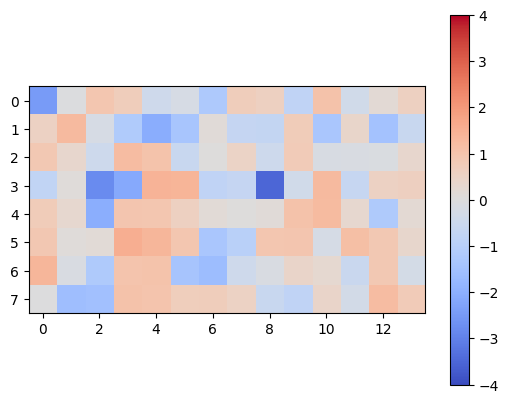

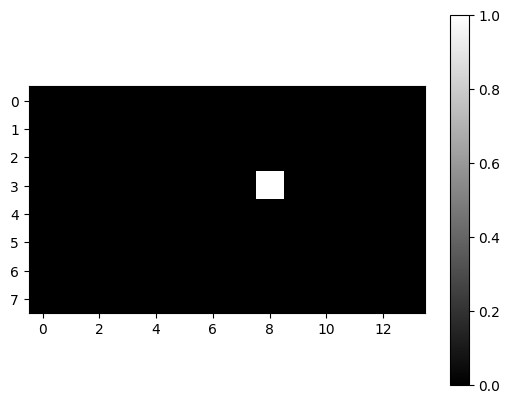

In [95]:
sta = (pixels_off * sweep_responses_roi).sum(axis=2) / sweep_responses_roi.sum()

sta = (sta - sta.mean()) / sta.std()

subfield = sta < -3
sub = plt.imshow(sta[:, :], cmap='coolwarm', vmin=-4, vmax=4)
plt.colorbar(sub)

plt.figure()
sub = plt.imshow(subfield[:, :], cmap='binary_r')
plt.colorbar(sub)

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import numpy as np

def ridge_cv(X, y, alphas=np.logspace(-2, 4, 20), n_splits=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    best_a, best_score = None, -np.inf

    for a in alphas:
        scores = []
        for tr, te in kf.split(X):
            model = Ridge(alpha=a, fit_intercept=True)
            model.fit(X[tr], y[tr])
            # R^2 on heldout (or correlation)
            scores.append(model.score(X[te], y[te]))
        m = np.mean(scores)
        if m > best_score:
            best_score, best_a = m, a

    model = Ridge(alpha=best_a, fit_intercept=True).fit(X, y)
    return model, best_a, best_score

In [116]:
sweeps_shuf = np.random.permutation(lsn.sweep_responses[:, roi])

In [12]:
design_matrix_int = lsn.design_matrix.astype(int)  # shape (2*n_pixels, n_sweeps)

In [13]:
model, best_a, best_score = ridge_cv(design_matrix_int.T, lsn.sweep_responses[:, 0])
w = model.coef_  # shape (2*n_pixels,)
b = model.intercept_  # scalar

w_on = w[:112].reshape(*lsn.image_shape)
w_off = w[112:].reshape(*lsn.image_shape)

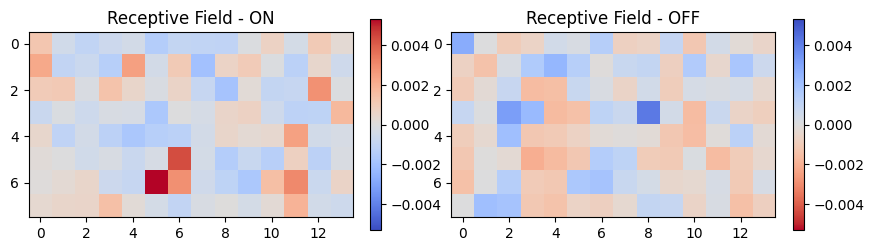

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].imshow(w_on, cmap='coolwarm', vmin=-np.max(np.abs(w)), vmax=np.max(np.abs(w)))
axs[0].set_title('Receptive Field - ON')
plt.colorbar(im1, ax=axs[0], fraction=0.03)

im2 = axs[1].imshow(w_off, cmap='coolwarm_r', vmin=-np.max(np.abs(w)), vmax=np.max(np.abs(w)))
axs[1].set_title('Receptive Field - OFF')
plt.colorbar(im2, ax=axs[1], fraction=0.03)

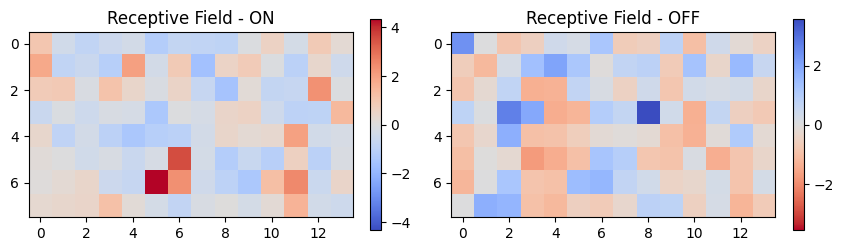

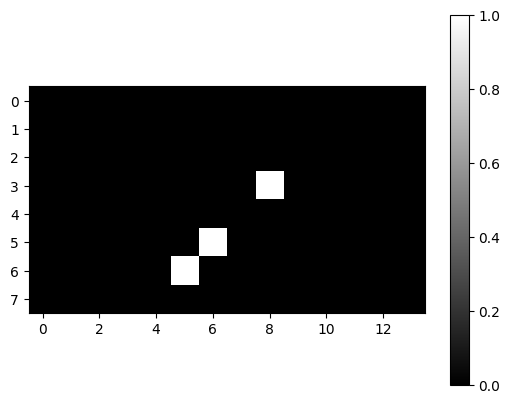

In [130]:
w_on_zscored = (w_on - w_on.mean()) / w_on.std()
w_off_zscored = (w_off - w_off.mean()) / w_off.std()

threshold = 3
subfield = (w_on_zscored > threshold) | (w_off_zscored > threshold)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].imshow(w_on_zscored, cmap='coolwarm', vmin=-np.max(np.abs(w_on_zscored)), vmax=np.max(np.abs(w_on_zscored)))
axs[0].set_title('Receptive Field - ON')
plt.colorbar(im1, ax=axs[0], fraction=0.03)

im2 = axs[1].imshow(w_off_zscored, cmap='coolwarm_r', vmin=-np.max(np.abs(w_off_zscored)), vmax=np.max(np.abs(w_off_zscored)))
axs[1].set_title('Receptive Field - OFF')
plt.colorbar(im2, ax=axs[1], fraction=0.03)

plt.figure()
sub = plt.imshow(subfield[:, :], cmap='binary_r')
plt.colorbar(sub)